Chargement du dataset ML final...
Dataset chargé. Shape: (836126, 29)
Définition des features pour le Modèle A (Démo uniquement)...
Features (X) sélectionnées: ['categorieJuridiqueUniteLegale', 'trancheEffectifsUniteLegale', 'activitePrincipaleUniteLegale', 'departement']
Target (y) sélectionnée: is_failed_in_3y
Ratio de déséquilibre (scale_pos_weight): 69.54
Création de la pipeline (Preprocessor + XGBoost)...
Entraînement du Modèle A (Baseline)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:26:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle A...
---
--- RÉSULTATS DU MODÈLE A (BASELINE 'DÉMO') ---
Score ROC-AUC (Baseline): 0.7619
---
Rapport de Classification (Baseline):
               precision    recall  f1-score   support

Survivant (0)       1.00      0.59      0.74    164855
 Faillite (1)       0.03      0.83      0.05      2371

     accuracy                           0.59    167226
    macro avg       0.51      0.71      0.40    167226
 weighted avg       0.98      0.59      0.73    167226

---
Matrice de Confusion (Baseline):


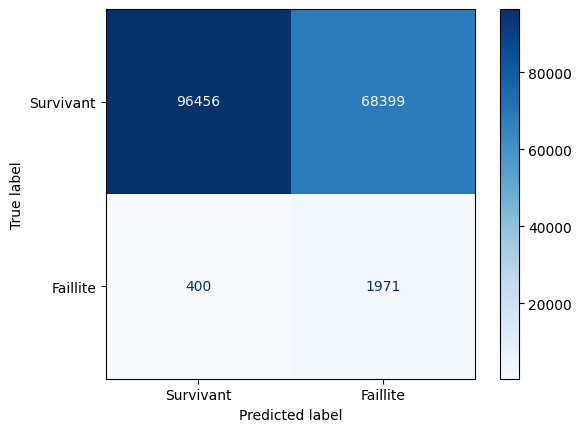

In [8]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL ---
print("Chargement du dataset ML final...")
try:
    df_final_ml = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset chargé. Shape: {df_final_ml.shape}")
except Exception as e:
    print("ERREUR: Fichier 'cohort_FINAL_ML_READY.parquet' non trouvé.")
    print("Assure-toi d'avoir lancé le notebook 01_EDA.ipynb d'abord.")

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 1) ---
print("Définition des features pour le Modèle A (Démo uniquement)...")

# C'est notre 1ère "modification de features" : on ne prend QUE les features SIRENE
DEMO_FEATURES = [
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    # "categorieEntreprise",  # Souvent redondant avec trancheEffectifs
    # "economieSocialeSolidaireUniteLegale", # Souvent peu d'info
    # "societeMissionUniteLegale", # Souvent peu d'info
    "departement"
]

TARGET = "is_failed_in_3y"

# On convertit en Pandas pour Scikit-Learn
X = df_final_ml.select(DEMO_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze() # .squeeze() pour en faire une Série

print(f"Features (X) sélectionnées: {X.columns.to_list()}")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE ---
# On calcule le ratio pour 'scale_pos_weight'
# (Nombre de 0 / Nombre de 1)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Ratio de déséquilibre (scale_pos_weight): {scale_pos_weight:.2f}")

# --- 4. PRÉPARATION (Preprocessing) ---
# Nos features sont toutes catégorielles. On doit les One-Hot Encoder.
categorical_features = DEMO_FEATURES
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# On crée un "ColumnTransformer" qui appliquera le OHE à nos colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="passthrough" # Ne touche pas aux autres colonnes (s'il y en avait)
)

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
print("Création de la pipeline (Preprocessor + XGBoost)...")

model_A = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42,
        enable_categorical=False # On le désactive car on fait un OHE
    ))
])

# --- 7. ENTRAÎNEMENT (Baseline) ---
print("Entraînement du Modèle A (Baseline)...")
model_A.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Baseline") ---
print("Évaluation du Modèle A...")
y_pred = model_A.predict(X_test)
y_pred_proba = model_A.predict_proba(X_test)[:, 1]

# Scores
auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE A (BASELINE 'DÉMO') ---")
print(f"Score ROC-AUC (Baseline): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Baseline):")
print(report)
print("---")

# Plot Matrice de Confusion
print("Matrice de Confusion (Baseline):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Chargement du dataset ML final (836k lignes)...
Dataset chargé. Shape: (836126, 29)
Définition des features pour le Modèle A (Démo uniquement)...
Features (X) sélectionnées: ['categorieJuridiqueUniteLegale', 'trancheEffectifsUniteLegale', 'activitePrincipaleUniteLegale', 'departement']
Target (y) sélectionnée: is_failed_in_3y
Ratio de déséquilibre (sur 836k lignes): 69.54
Création de la pipeline (Preprocessor + XGBoost)...
Entraînement du Modèle A (Baseline)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle A...
---
--- RÉSULTATS DU MODÈLE A (BASELINE 'DÉMO') ---
Score ROC-AUC (Baseline): 0.7619
---
Rapport de Classification (Baseline):
               precision    recall  f1-score   support

Survivant (0)       1.00      0.59      0.74    164855
 Faillite (1)       0.03      0.83      0.05      2371

     accuracy                           0.59    167226
    macro avg       0.51      0.71      0.40    167226
 weighted avg       0.98      0.59      0.73    167226

---
Matrice de Confusion (Baseline):


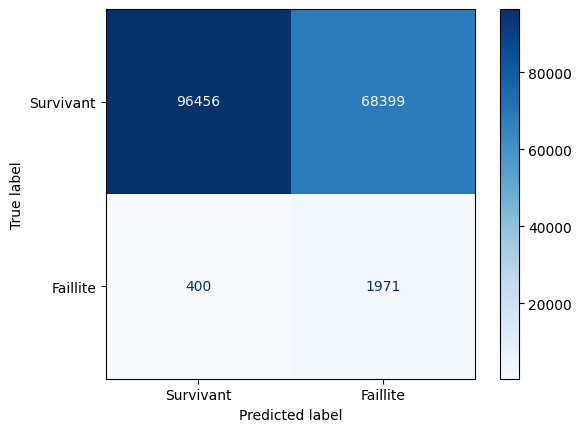

In [9]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL (LE COMPLET) ---
print("Chargement du dataset ML final (836k lignes)...")
try:
    df_final_ml = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset chargé. Shape: {df_final_ml.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 1 : DÉMO) ---
print("Définition des features pour le Modèle A (Démo uniquement)...")

DEMO_FEATURES = [
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    # "categorieEntreprise", # Redondant
    # "economieSocialeSolidaireUniteLegale", # Trop peu de '1'
    # "societeMissionUniteLegale", # Trop peu de '1'
    "departement"
]

TARGET = "is_failed_in_3y"

# On convertit en Pandas pour Scikit-Learn
X = df_final_ml.select(DEMO_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {X.columns.to_list()}")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE (sur 836k lignes) ---
# (Nombre de 0 / Nombre de 1)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Ratio de déséquilibre (sur 836k lignes): {scale_pos_weight:.2f}")

# --- 4. PRÉPARATION (Preprocessing) ---
# Nos features sont toutes catégorielles. On doit les One-Hot Encoder.
categorical_features = DEMO_FEATURES
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="passthrough"
)

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
print("Création de la pipeline (Preprocessor + XGBoost)...")

model_A = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42,
        enable_categorical=False # On le désactive car on fait un OHE
    ))
])

# --- 7. ENTRAÎNEMENT (Baseline) ---
print("Entraînement du Modèle A (Baseline)...")
model_A.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Baseline") ---
print("Évaluation du Modèle A...")
y_pred = model_A.predict(X_test)
y_pred_proba = model_A.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE A (BASELINE 'DÉMO') ---")
print(f"Score ROC-AUC (Baseline): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Baseline):")
print(report)
print("---")

# Plot Matrice de Confusion
print("Matrice de Confusion (Baseline):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [1]:
import polars as pl
import sys
import os

print("--- Lancement Data Prep (Version Notebook) ---")

# --- LA CORRECTION "NOTEBOOK" ---
# On enlève la magie "__file__" et on utilise des chemins relatifs
# On part de /Notebooks/ et on remonte avec "../"
PATH_UL = "../Data/raw/StockUniteLegale_utf8.parquet"
PATH_ETAB = "../Data/raw/StockEtablissement_utf8.parquet"
PATH_ETAB_HISTO = "../Data/raw/StockEtablissementHistorique_utf8.parquet"
PATH_OUTPUT = "../Data/processed/sirene_infos2.parquet" # On utilise le bon nom
# --- FIN DE LA CORRECTION ---


print("--- Lancement Script 01: Création du MASTER FILE SIRENE (v3) ---")

# (Vérification des 3 fichiers...)
for path in [PATH_UL, PATH_ETAB, PATH_ETAB_HISTO]:
    if not os.path.exists(path):
        print(f"ERREUR FATALE: Fichier brut manquant : {path}", file=sys.stderr)
        raise FileNotFoundError(f"Fichier non trouvé : {path}")

# ===================================================================
# ÉTAPE 1: La Base (FEATURES X) - Fichier 'StockUniteLegale'
# ===================================================================
print("Étape 1: Lecture des features de 'StockUniteLegale'...")
df_base_features = pl.scan_parquet(PATH_UL).select(
    "siren",
    "dateCreationUniteLegale",
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "categorieEntreprise",                 # <-- AJOUTÉ
    "economieSocialeSolidaireUniteLegale", # <-- AJOUTÉ
    "societeMissionUniteLegale"            # <-- AJOUTÉ
)

# ===================================================================
# ÉTAPE 2: Trouver le SIRET du Siège (HQ) - Fichier 'StockEtablissement'
# ===================================================================
print("Étape 2: Lecture de 'StockEtablissement' pour trouver les sièges...")
df_sieges = pl.scan_parquet(PATH_ETAB).filter(
    pl.col("etablissementSiege") == True
).select(
    "siren", 
    "siret",
    pl.col("codePostalEtablissement").str.slice(0, 2).alias("departement")
)

# ===================================================================
# ÉTAPE 3: Trouver la Date de Fermeture (La Cible Y) - Fichier 'StockEtablissementHistorique'
# ===================================================================
print("Étape 3: Lecture de 'StockEtablissementHistorique' pour trouver les 'morts'...")
df_fermetures = pl.scan_parquet(PATH_ETAB_HISTO).filter(
    pl.col("etatAdministratifEtablissement") == 'F'
).select(
    "siret",
    pl.col("dateFin").alias("dateFermeture")
).group_by("siret").agg(
    pl.col("dateFermeture").max() 
)

# ===================================================================
# ÉTAPE 4: Le "Grand Mariage" SIRENE
# ===================================================================
print("Étape 4: Jointure finale des 3 tables...")
df_master = df_base_features.join(df_sieges, on="siren", how="left")
df_master = df_master.join(df_fermetures, on="siret", how="left")

# ===================================================================
# ÉTAPE 5: Sauvegarde
# ===================================================================
print(f"Sauvegarde du Master File dans {PATH_OUTPUT}...")
df_final = df_master.select(
    "siren",
    "dateCreationUniteLegale",
    "dateFermeture",
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "categorieEntreprise",
    "economieSocialeSolidaireUniteLegale",
    "societeMissionUniteLegale",
    "departement"
)

# On s'assure que le dossier 'processed' existe
os.makedirs(os.path.dirname(PATH_OUTPUT), exist_ok=True)

# On collecte et on sauvegarde
df_final.collect().write_parquet(PATH_OUTPUT)
print(f"--- Script 01 (Master File) Terminé avec Succès ---")

--- Lancement Data Prep (Version Notebook) ---
--- Lancement Script 01: Création du MASTER FILE SIRENE (v3) ---
Étape 1: Lecture des features de 'StockUniteLegale'...
Étape 2: Lecture de 'StockEtablissement' pour trouver les sièges...
Étape 3: Lecture de 'StockEtablissementHistorique' pour trouver les 'morts'...
Étape 4: Jointure finale des 3 tables...
Sauvegarde du Master File dans ../Data/processed/sirene_infos2.parquet...


ColumnNotFoundError: unable to find column "dateCreationUniteLegale"; valid columns: ["siren", "nic", "siret", "statutDiffusionEtablissement", "dateCreationEtablissement", "trancheEffectifsEtablissement", "anneeEffectifsEtablissement", "activitePrincipaleRegistreMetiersEtablissement", "dateDernierTraitementEtablissement", "etablissementSiege", "nombrePeriodesEtablissement", "complementAdresseEtablissement", "numeroVoieEtablissement", "indiceRepetitionEtablissement", "dernierNumeroVoieEtablissement", "indiceRepetitionDernierNumeroVoieEtablissement", "typeVoieEtablissement", "libelleVoieEtablissement", "codePostalEtablissement", "libelleCommuneEtablissement", "libelleCommuneEtrangerEtablissement", "distributionSpecialeEtablissement", "codeCommuneEtablissement", "codeCedexEtablissement", "libelleCedexEtablissement", "codePaysEtrangerEtablissement", "libellePaysEtrangerEtablissement", "identifiantAdresseEtablissement", "coordonneeLambertAbscisseEtablissement", "coordonneeLambertOrdonneeEtablissement", "complementAdresse2Etablissement", "numeroVoie2Etablissement", "indiceRepetition2Etablissement", "typeVoie2Etablissement", "libelleVoie2Etablissement", "codePostal2Etablissement", "libelleCommune2Etablissement", "libelleCommuneEtranger2Etablissement", "distributionSpeciale2Etablissement", "codeCommune2Etablissement", "codeCedex2Etablissement", "libelleCedex2Etablissement", "codePaysEtranger2Etablissement", "libellePaysEtranger2Etablissement", "dateDebut", "etatAdministratifEtablissement", "enseigne1Etablissement", "enseigne2Etablissement", "enseigne3Etablissement", "denominationUsuelleEtablissement", "activitePrincipaleEtablissement", "nomenclatureActivitePrincipaleEtablissement", "caractereEmployeurEtablissement"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
Parquet SCAN [../Data/raw/StockUniteLegale_utf8.parquet]
PROJECT */53 COLUMNS
ESTIMATED ROWS: 42151993